In [234]:
# libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema  # Local minima detection
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path
import os
import sys
sys.path.append(os.path.abspath("../classification/cycle_splits/"))
from utils import compute_relative_keypoints, normalize_signal, smooth_signal, load_json

In [235]:
# Function to process data from a dataset
def process_data(data, keypoint_indices):
    frames = sorted(set(anno["image_id"] for anno in data.get("annotations", [])))
    
    keypoint_movements = {}
    for joint, index in keypoint_indices.items():
        keypoints_per_joint = {"x": [], "y": []}
        
        for annotation in data.get("annotations", []):
            keypoints = annotation["keypoints"]
            
            # for the choosen reference joint we save the absolute values
            if joint == CHOOSEN_REF:
                absolute_keypoints = []
                for i in range(0, len(keypoints), 3):
                    x, y, v = keypoints[i:i+3]
                    if v == 0:
                        x, y = None, None
                    absolute_keypoints.append((x, y))
                joint_x, joint_y = absolute_keypoints[index]
            # for other joints we save keypoints relative to our reference joints
            else:
                relative_keypoints = compute_relative_keypoints(keypoints, keypoint_indices[CHOOSEN_REF])
                joint_x, joint_y = relative_keypoints[index]

            keypoints_per_joint["x"].append(joint_x)
            keypoints_per_joint["y"].append(joint_y)
            
        keypoint_movements[joint] = keypoints_per_joint

    return frames, keypoint_movements  

In [236]:
# Function to create a dynamic plot for the X values
def create_x_plot(frames, x_values, current_frame):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
    ax.plot(frames[:current_frame + 1], x_values[:current_frame + 1], color='red', label=CHOOSEN_JOINT + ' ' + CHOOSEN_DIM)
    ax.set_xlim([frames[0], frames[-1]])
    ax.set_ylim(min(x_values) - 1, max(x_values) + 1)
    ax.set_xlabel("Frame")
    ax.set_ylabel(CHOOSEN_DIM + " Position")
    ax.legend(loc="upper left")

    canvas = FigureCanvas(fig)
    canvas.draw()
    plot_image = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    plot_image = plot_image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return plot_image

In [238]:
def play_video_with_x_plot(video_path, frames, x_values_raw, x_values_smoothed, min_indices, cycles, frame_rate=30, output_path="output_video.mp4"):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define video writer (use same frame size & frame rate)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for MP4 output
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

    frame_idx = 0  # Start from the first frame
    while frame_idx < total_frames:
        ret, frame = cap.read()
        if not ret:
            print(f"Error: Could not read frame {frame_idx}.")
            break

        # Find current cycle label
        current_label = ""
        current_cycle_id = "Cycle -"
        for cycle in cycles:
            cycle_id, start_frame, end_frame, label = cycle
            if start_frame <= frame_idx <= end_frame:
                current_label = label
                current_cycle_id = cycle_id
                break  

        # Overlay X plot
        plot_image = create_x_plot(frames, x_values_smoothed, frame_idx)
        plot_height, plot_width = plot_image.shape[:2]
        plot_resized = cv2.resize(plot_image, (frame_width // 3, int(plot_height * (frame_width // 3) / plot_width)))

        # Overlay plot on frame
        roi = frame[0:plot_resized.shape[0], frame_width - plot_resized.shape[1]:]
        overlayed_frame = cv2.addWeighted(roi, 0.2, plot_resized, 1, 0)
        frame[0:plot_resized.shape[0], frame_width - plot_resized.shape[1]:] = overlayed_frame

        # Display cycle label on the video
        label_text = f"{current_cycle_id} Label: {current_label}"
        cv2.putText(frame, label_text, (1420, 350), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 5, cv2.LINE_AA)
        cv2.putText(frame, label_text, (1420, 350), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Show frame
        cv2.imshow("Video with X Plot", frame)

        # Write frame to output video
        out.write(frame)

        # Handle user input
        key = cv2.waitKey(1000 // frame_rate) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('r'):  # Restart video
            frame_idx = 0
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            continue
        
        frame_idx += 1  # Move to the next frame

    cap.release()
    out.release()  # Save the output video
    cv2.destroyAllWindows()
    print(f"Video saved to {output_path}")


In [239]:
CHOOSEN_JOINT = "RAnkle"
CHOOSEN_REF = "Hip"
CHOOSEN_DIM = "x"
sigma_value = 2  # Adjust smoothing strength
order = 22 # How sensetive to find local minima
#LABELS = ["g2", "g3", "g4", "unknown"]
LABELS = {
    "2" : "gear2",
    "3" : "gear3",
    "4" : "gear4",
    "u" : "unknown"
}
CHOOSEN_KEYPOINTS = [CHOOSEN_JOINT, CHOOSEN_REF,"LShoulder","RShoulder","LElbow","RElbow","LWrist","RWrist","LHip","RHip","LKnee","RKnee","LAnkle","Head","Neck","LBigToe","RBigToe","LSmallToe","RSmallToe","LHeel","RHeel"]

In [240]:

VIDEO_DIR = "/Users/emillundin/Desktop/Ski_project/Cut_videos/"  # Replace with your video file
ANNO_DIR = "/Users/emillundin/Desktop/Ski_project/Annotations_from_CVAT/annotations_manually adjusted/annotations_manually_adjusted"
video_id ="18" # 11, 13, 27, 32, 36, 42, 16_cut, 19_cut, 20_cut, 21_cut, 23_cut, 33, 34, 53 (annotations from finetuned model)
file_path = os.path.join(ANNO_DIR, video_id + ".json")
json_path_labels = f"/Users/emillundin/Desktop/Ski_project/Annotated_cycles_backup/labeled_cycles_{video_id}.json"  # Update with correct path

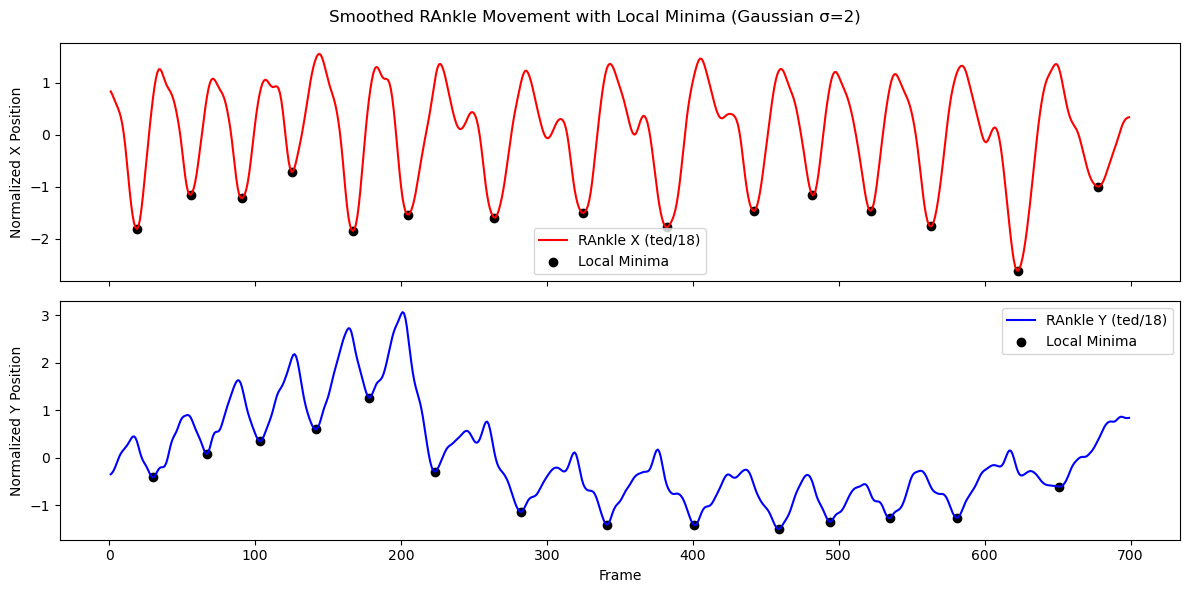

In [241]:
# Load JSON data
dataset = load_json(file_path)

# Extract keypoint labels (assumes same structure across files)
keypoint_labels = dataset["categories"][0]["keypoints"]
#hip_index = keypoint_labels.index("Hip")  # Find the index of the "Hip" keypoint
#lankle_index = keypoint_labels.index(CHOOSEN_JOINT)  # Find index for joint we choose
keypoint_indices = {joint: keypoint_labels.index(joint) for joint in CHOOSEN_KEYPOINTS}

# Process dataset, get keypoints and frames
frames, keypoints = process_data(dataset, keypoint_indices)

# Normalize and smooth all datasets
smoothed_normalized_keypoints = {"x": [], "y": []}
smoothed_normalized_keypoints["x"] = normalize_signal(keypoints[CHOOSEN_JOINT]["x"])
smoothed_normalized_keypoints["y"] = normalize_signal(keypoints[CHOOSEN_JOINT]["y"])

smoothed_normalized_keypoints["x"] = smooth_signal(smoothed_normalized_keypoints["x"], sigma=sigma_value)
smoothed_normalized_keypoints["y"] = smooth_signal(smoothed_normalized_keypoints["y"], sigma=sigma_value)

# Plot Joint movement (X and Y in separate plots)
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Detect local minima for X movement
x_values = np.array(smoothed_normalized_keypoints["x"])
x_min_indices = argrelextrema(x_values, np.less, order=order)[0]  

# Detect local minima for Y movement
y_values = np.array(smoothed_normalized_keypoints["y"])
y_min_indices = argrelextrema(y_values, np.less, order=order)[0]  

# Plot choosen joint X movement
axs[0].plot(frames, x_values, label=f"{CHOOSEN_JOINT} X ({file_path[-11:-5]})", color="red")
axs[0].scatter(np.array(frames)[x_min_indices], x_values[x_min_indices], color="black", marker="o", label="Local Minima")
axs[0].set_ylabel("Normalized X Position")
axs[0].legend()

# Plot choosen joint Y movement
axs[1].plot(frames, y_values, label=f"{CHOOSEN_JOINT} Y ({file_path[-11:-5]})", color="blue")
axs[1].scatter(np.array(frames)[y_min_indices], y_values[y_min_indices], color="black", marker="o", label="Local Minima")
axs[1].set_ylabel("Normalized Y Position")
axs[1].set_xlabel("Frame")
axs[1].legend()

plt.suptitle(f"Smoothed {CHOOSEN_JOINT} Movement with Local Minima (Gaussian σ={sigma_value})")
plt.tight_layout()
plt.show()

In [242]:
def load_cycles(json_path):
    """
    Loads the JSON file and extracts start and end frames for each cycle along with its label.
    
    Parameters:
        json_path (str): Path to the JSON file.
    
    Returns:
        list of tuples: Each tuple contains (label, start_frame, end_frame).
    """
    with open(json_path, 'r') as file:
        data = json.load(file)

    cycle_info = []
    
    
    for cycle_label, values in data.items():
        if not values:
            continue  # Skip empty cycles
        
        # The frame indices are inferred from the length of the joint data
        start_frame = values["Start_frame"]
        end_frame = values["End_frame"]  # Get length from any joint data
        label = values["Label"]
        
        cycle_info.append((cycle_label, start_frame, end_frame, label))

    return cycle_info

# Example usage
json_path_labels = f"/Users/emillundin/Desktop/Ski_project/Annotated_cycles_backup/labeled_cycles_{video_id}_cut.json"  # Update with correct path
cycles = load_cycles(json_path_labels)

for cycle in cycles:
    print(f"Cycle: {cycle[0]}, Start Frame: {cycle[1]}, End Frame: {cycle[2]}, Label: {cycle[3]}")

print(cycles)


Cycle: Cycle 1, Start Frame: 19, End Frame: 56, Label: gear2
Cycle: Cycle 2, Start Frame: 56, End Frame: 91, Label: gear2
Cycle: Cycle 3, Start Frame: 91, End Frame: 125, Label: gear2
Cycle: Cycle 4, Start Frame: 125, End Frame: 167, Label: gear2
Cycle: Cycle 5, Start Frame: 167, End Frame: 205, Label: gear2
Cycle: Cycle 6, Start Frame: 205, End Frame: 264, Label: gear3
Cycle: Cycle 7, Start Frame: 264, End Frame: 325, Label: gear3
Cycle: Cycle 8, Start Frame: 325, End Frame: 382, Label: gear3
Cycle: Cycle 9, Start Frame: 382, End Frame: 442, Label: gear3
Cycle: Cycle 10, Start Frame: 442, End Frame: 482, Label: gear2
Cycle: Cycle 11, Start Frame: 482, End Frame: 522, Label: gear2
Cycle: Cycle 12, Start Frame: 522, End Frame: 563, Label: gear2
Cycle: Cycle 13, Start Frame: 563, End Frame: 623, Label: gear3
Cycle: Cycle 14, Start Frame: 623, End Frame: 678, Label: unknown
[('Cycle 1', 19, 56, 'gear2'), ('Cycle 2', 56, 91, 'gear2'), ('Cycle 3', 91, 125, 'gear2'), ('Cycle 4', 125, 167, 'g

In [243]:
# Get the corresponding X values for each frame
#keypoints = {"LAnkle" : {"x": [], "y" : []}}
keypoint_values = {}
for joint, values in keypoints.items(): 
    if joint == CHOOSEN_REF:
        key_x, key_y = joint + "_x_ref", joint + "_y_ref"
    else:
        key_x, key_y = joint + "_x", joint + "_y"
    keypoint_values[key_x], keypoint_values[key_y] = values["x"], values["y"]
    
# keypoint_values = {"LAnkle_x": [], "LAnkle_y": [], ...}
    
x_values_smoothed = [smoothed_normalized_keypoints[CHOOSEN_DIM][i] for i in range(len(frames))]

# Video path
video_path = os.path.join(VIDEO_DIR, "DJI_00" + video_id + "_cut.mp4")

if CHOOSEN_DIM == "x":
    min_indices = x_min_indices
else:
    min_indices = y_min_indices

print(keypoints)
    
# Run the function
play_video_with_x_plot(video_path, frames, keypoint_values, x_values_smoothed, min_indices, cycles, frame_rate=24)

{'RAnkle': {'x': [9.599999999999909, 7.880000000000109, 5.940000000000055, 4.7000000000000455, 3.4400000000000546, 3.240000000000009, 2.090000000000032, 1.7300000000000182, -0.8399999999999181, -3.669999999999959, -7.07000000000005, -13.210000000000036, -19.120000000000005, -25.06000000000006, -30.519999999999982, -34.33999999999992, -35.60000000000002, -37.16999999999996, -39.069999999999936, -38.48000000000013, -35.92000000000007, -32.26999999999998, -26.019999999999982, -21.59999999999991, -16.160000000000082, -11.3599999999999, -5.470000000000027, -3.880000000000109, 4.970000000000027, 6.680000000000064, 10.5, 14.75, 15.919999999999845, 18.24000000000001, 18.410000000000082, 14.75, 14.049999999999955, 9.720000000000027, 10.059999999999945, 9.910000000000082, 7.610000000000127, 9.980000000000018, 7.669999999999845, 6.5, 5.210000000000036, 2.150000000000091, -1.0799999999999272, -2.980000000000018, -3.7199999999998, -9.680000000000064, -15.289999999999964, -20.660000000000082, -25.82